In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from tqdm import tqdm
import cv2

## Load All Image into one file

In [5]:
n_train = 25000
img_db = []
for i in tqdm(range(12500)):
    img = cv2.imread('D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\train\\cat\\' + str(i) + '.jpg', cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (500, 500))
    img = np.array(img, dtype=np.uint8)
    img = img[None, :]
    img_db.append(img)
    
for i in tqdm(range(12500)):
    img = cv2.imread('D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\train\\dog\\' + str(i) + '.jpg', cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (500, 500))
    img = np.array(img, dtype=np.uint8)
    img = img[None, :]
    img_db.append(img)

img_db = np.vstack(img_db)

100%|███████████████████████████████████████████████████| 12500/12500 [00:29<00:00, 420.65it/s]


In [6]:
img_db.shape

(25000, 500, 500, 3)

## Save img_db to Pickle file

In [7]:
import sys
sys.getsizeof(img_db)

18750000144

In [5]:
img_db = np.array(img_db)
zeros = np.zeros(12500, dtype=np.uint8)
ones = np.ones(12500, dtype=np.uint8)
labels = np.concatenate((zeros, ones))
obj = {'img': img_db, 'labels': labels}
with open('data.p', 'wb') as file:
    pickle.dump(obj, file)

## Data Exploration

In [22]:
height = []
width = []
for i in img_db:
    height.append(i.shape[0])
    width.append(i.shape[1])

In [40]:
print("Picture # that has maximum height:", height.index(max(height)))
print("Picture # that has maximum width:", width.index(max(width)))

Picture # that has maximum height: 835
Picture # that has maximum width: 835


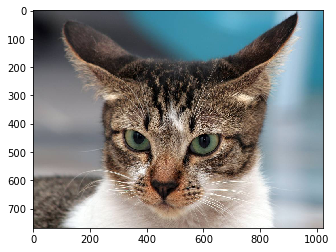

Size =  (768, 1023, 3)


In [34]:
plt.imshow(img_db[835], cmap='gray')
plt.show()
print("Size = ", img_db[835].shape)

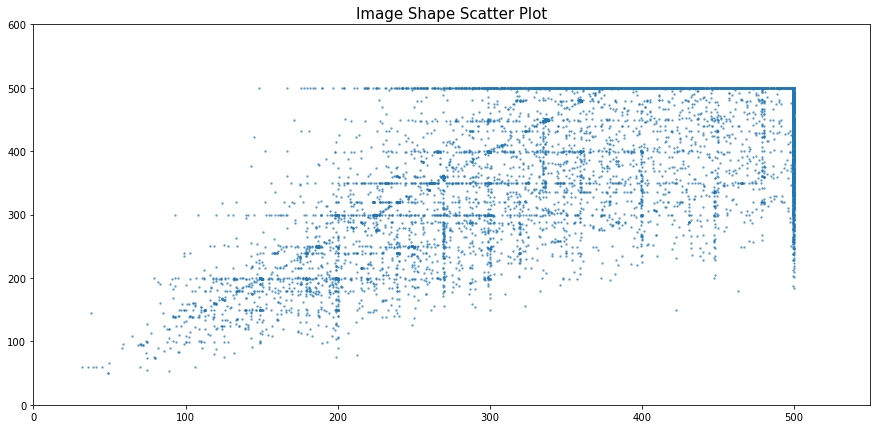

In [39]:
plt.figure(figsize=[15, 7])
plt.scatter(height, width, alpha=0.3, s=2)
plt.axis([0, 550, 0, 600])
plt.title("Image Shape Scatter Plot", size=15)
plt.show()

## Unify Image Size

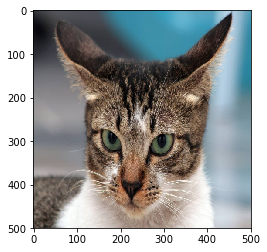

In [45]:
img = cv2.imread('D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\train\\cat\\835.jpg', cv2.IMREAD_COLOR)
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
img = cv2.resize(img, (500, 500))
plt.imshow(np.array(img), cmap='gray')
plt.show()

## Create Model

In [16]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

#CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> Fully-Connected X 4 -> output
def create_model(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    # Flatten
    x = Flatten()(x)
    # Dropout
    x = Dropout(0.25)(x)
    # Fully-Connected Layer
    x = Dense(2, activation='softmax', name='class')(x)

    model = Model(inputs=input_tensor, outputs=x, name='dogVScat')
    return model

In [17]:
from keras.callbacks import EarlyStopping, TensorBoard, History

# 1. Create Model (3 CCM)
model = create_model(3, 32)

# 2. Compile Model with metrics/optimizer/loss
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [ ]:
model.fit(x=features, 
          y=encoded_labels, 
          batch_size=batch_size, 
          epochs=epoch, 
          verbose=1, 
          callbacks=None)